In [1]:
from preprocessing import transform_data_for_rnn
from data_scraper import scrape_udp_data
import torch
import torch.nn as nn
import numpy as np

buffer_size = 30

In [2]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [3]:
class StateEstimationDataset(torch.utils.data.Dataset):
    def __init__(self, motion_dir, udp_filename, buffer_size):
        scrape_udp_data(motion_dir, filename=udp_filename)
        self.X_data, self.y_data = transform_data_for_rnn(udp_filename, buffer_size)
        self.X_data = torch.from_numpy(self.X_data).to(device)
        self.y_data = torch.from_numpy(self.y_data).to(device)
    def __len__(self):
        return(self.X_data.shape[0])
    def __getitem__(self, idx):
        x = self.X_data[idx]
        y = self.y_data[idx]
        return x, y

udp_dataset = StateEstimationDataset(motion_dir=r"C:\\Users\\chros\\Documents\\Deep Racing\\australia_run1\\udp_data\\motion_packets", udp_filename="udp_data.pkl", buffer_size=buffer_size)
split_id = int(len(udp_dataset)* 0.8)
train_dataset, val_dataset = torch.utils.data.random_split(udp_dataset, [split_id, (len(udp_dataset) - split_id)])

Pickle file already exists


In [4]:
print(train_dataset.dataset.X_data.shape)
print(train_dataset.dataset.y_data.shape)

torch.Size([173300, 360])
torch.Size([173300, 90])


In [5]:
batch_size=32
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [6]:
class StateEstimationNet(nn.Module):
    def __init__(self, buffer_size, input_shape, hidden_dim, n_layers, batch_size, drop_prob=0.0002):
        super().__init__()
        self.output_size = 3 * buffer_size
        self.input_shape = input_shape
        self.n_layers = n_layers
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_shape, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.fc = nn.Linear(hidden_dim, self.output_size)

    def forward(self, x, hidden):
        x = x.float()
        x = torch.unsqueeze(x, 1)
        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(lstm_out)
        out = out.view(self.batch_size, -1)
        return out, hidden
    
    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, self.batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, self.batch_size, self.hidden_dim).zero_().to(device))
        return hidden


In [7]:
model = StateEstimationNet(buffer_size=buffer_size, input_shape=udp_dataset.X_data.shape[-1], hidden_dim=32, n_layers=3, batch_size=batch_size)
model.to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

In [8]:
print(model)

StateEstimationNet(
  (lstm): LSTM(360, 32, num_layers=3, batch_first=True, dropout=0.0002)
  (fc): Linear(in_features=32, out_features=90, bias=True)
)


In [9]:
epochs = 100
valid_loss_min = np.Inf
model_path = './state_dict_' + str(buffer_size) + '.pt'

model.train()
for i in range(epochs):
    h = model.init_hidden()
    for inputs, labels in train_data_loader:
        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        output, h = model(inputs, h)
        loss = loss_function(output.squeeze(), labels.float())
        loss.backward()
        optimizer.step()

    val_h = model.init_hidden()
    val_losses = []
    model.eval()
    for inp, lab in val_data_loader:
        val_h = tuple([each.data for each in val_h])
        inp, lab = inp.to(device), lab.to(device)
        out, val_h = model(inp, val_h)
        val_loss = loss_function(out.squeeze(), lab.float())
        val_losses.append(val_loss.item())
    model.train()
    if np.mean(val_losses) <= valid_loss_min:
        torch.save(model.state_dict(), model_path)
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
        valid_loss_min = np.mean(val_losses)
    print("Epoch: {}/{}...".format(i+1, epochs),
          "Loss: {:.6f}...".format(loss.item()),
          "Val Loss: {:.6f}".format(np.mean(val_losses)))

Validation loss decreased (inf --> 58430.890675).  Saving model ...
Epoch: 1/100... Loss: 53864.324219... Val Loss: 58430.890675
Validation loss decreased (58430.890675 --> 22478.981515).  Saving model ...
Epoch: 2/100... Loss: 23026.380859... Val Loss: 22478.981515
Validation loss decreased (22478.981515 --> 4697.685214).  Saving model ...
Epoch: 3/100... Loss: 5683.958008... Val Loss: 4697.685214
Validation loss decreased (4697.685214 --> 669.192844).  Saving model ...
Epoch: 4/100... Loss: 650.471375... Val Loss: 669.192844
Validation loss decreased (669.192844 --> 137.050429).  Saving model ...
Epoch: 5/100... Loss: 180.202408... Val Loss: 137.050429
Validation loss decreased (137.050429 --> 83.554421).  Saving model ...
Epoch: 6/100... Loss: 115.125328... Val Loss: 83.554421
Validation loss decreased (83.554421 --> 54.557761).  Saving model ...
Epoch: 7/100... Loss: 37.041828... Val Loss: 54.557761
Epoch: 8/100... Loss: 58.255165... Val Loss: 57.392832
Validation loss decreased (5

In [11]:
model.load_state_dict(torch.load('./state_dict_30.pt'))
test_losses = []
predictions = []
ground_truth = []

h = model.init_hidden()
model.eval()
for inputs, labels in val_data_loader:
    h = tuple([each.data for each in h])
    inputs, labels = inputs.to(device), labels.to(device)
    output, h = model(inputs, h)
    test_loss = loss_function(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    predictions.append(output.squeeze())
    ground_truth.append(labels.cpu())

print("Validation loss: {:.3f}".format(np.mean(test_losses)))

Validation loss: 31.825


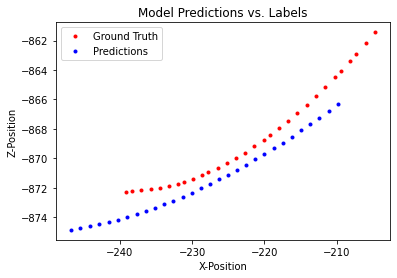

In [14]:
from visualize import visualize_waypoint_predictions

visualize_waypoint_predictions(ground_truth[102][5].cpu(), predictions[102][5].cpu().detach())

In [1]:
from preprocessing import filter_data_in_view
filtered_data = filter_data_in_view("udp_data.pkl", height=100, base=50)

100%|██████████| 8724/8724 [00:02<00:00, 3697.40it/s]


Timestamp not found. Closest value to desired time was used:  10.0133247


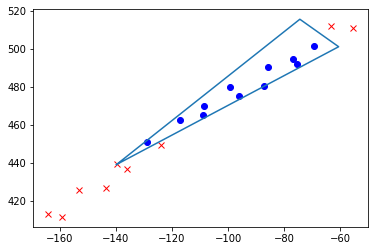

In [5]:
from visualize import visualize_ego_view

visualize_ego_view("udp_data.pkl", height=100, base=20, timestamp=10)